# Linear regression with gradient descent
## generate data
We generate `N=150` points following the distribution $$Y \~ a \times X + \epsilon$$ where $$\epsilon \~ N(0, 10)$$ is a Gaussian white noise, in order to satisfy linear regression conditions:

In [92]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [20, 5]

N = 150
a = 3.2

In [39]:
X = 100 * np.random.random(N)  # `N` random numbers between 0 and 100

# Generate y = a * x + eps where eps is 0-centered Gaussian distributed
Y = np.multiply(X, a)
eps = np.random.normal(scale=10, size=N)
Y = np.add(Y, eps)

## Compute gradient descent

The goal is to approximate the following red line:

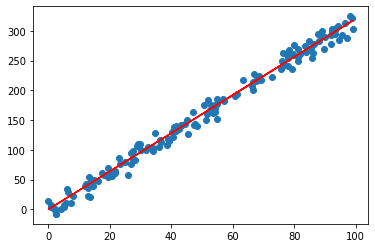

In [68]:
plt.scatter(X, Y)
plt.plot(X, a * X, c='r')
plt.show()


### Stochastic gradient descent

We define a function `gradient_descent_linreg()` iterating through all the points of the `(X, Y)` sample correcting each time `w` according to the loss and learning rate `lr`:

In [86]:
def gradient_descent_linreg(X, Y, lr, w):
    ws, losses = [], []
    for x, y in zip(X, Y):
        loss = (w * x - y) ** 2
        grad = 2 / N * (w * x - y ) * x
        w -= lr * grad
        ws.append(w)
        losses.append(loss)
    return {'w': ws, 'loss': losses}

In [87]:
descents = {lr: gradient_descent_linreg(X, Y, lr, w=10) for lr in [.0001, .001, .01]}

In [101]:
def plot_descents(descents, a):
    cmap = plt.cm.get_cmap('Blues', len(descents) + 1)
    plt.subplot(1, 2, 1)
    for i, (lr, res) in enumerate(descents.items()):
        plt.plot(range(len(res.get('w'))), res.get('w'), c=cmap(i+1), label=f'lr={lr}')
    xmax = max([len(v.get('w')) for v in descents.values()])
    plt.hlines(a, 0, xmax, colors='r', label='True Value')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('w')
    plt.title('Estimation of w by Iteration for Various Learning Rates')
    
    plt.subplot(1, 2, 2)
    for i, (lr, res) in enumerate(descents.items()):
        plt.plot(range(len(res.get('loss'))), res.get('loss'), c=cmap(i+1), label=f'lr={lr}')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('w')
    plt.title('Loss by Iteration for Various Learning Rates')
    
    plt.show()

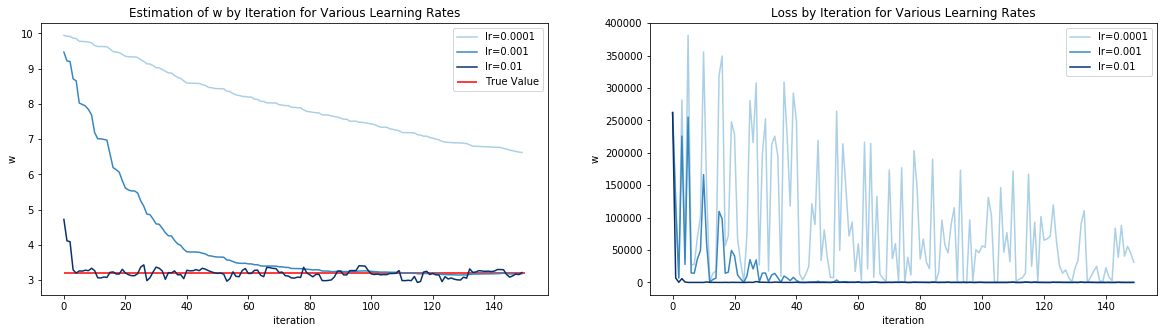

In [102]:
plot_descents(descents, a)

### Mini batch

In [108]:
def gradient_descent_linreg_batch(X, Y, lr, w, batch_size=5, n_iterations=100):
    ws, losses = [], []
    for _ in range(n_iterations):
        inds = np.random.choice(100, size=batch_size)
        x, y = X[inds], Y[inds]
        loss = np.mean(((w * x) - y) ** 2)
        grad = np.mean(2 / N * (w * x - y ) * x)
        w -= lr * grad
        ws.append(w)
        losses.append(loss)
    return {'w': ws, 'loss': losses}

In [109]:
descents = {lr: gradient_descent_linreg_batch(X, Y, lr, w=10) for lr in [.0001, .001, .01]}

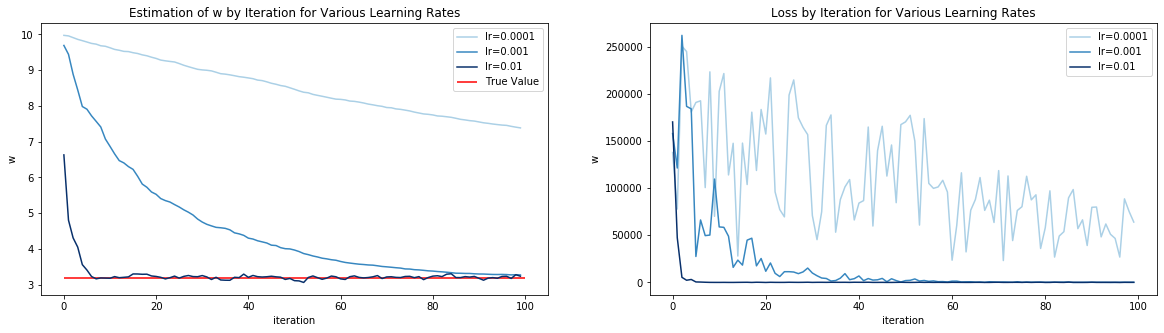

In [110]:
plot_descents(descents, a)